In [1]:
import sys
sys.path.append('..')
import os
import sklearn.metrics.cluster
import sklearn.cluster
import seaborn as sns
import scanpy as sc
import sklearn as sk
from sklearn.neighbors import NearestNeighbors
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import time
import numpy as np
import pandas as pd
import pickle
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages
import utils
import anndata
import anndata2ri
import gc
import benchmark_common_functions
import csv
from itertools import product
from copy import deepcopy
import pingouin as pg
from mpl_toolkits.axes_grid1 import AxesGrid

anndata2ri.activate()
ro.numpy2ri.activate()
readRDS = ro.r['readRDS']
%load_ext rpy2.ipython

def formatFloat(val):
    fmat = '%.2f'
    ret =  fmat % val
    if ret.startswith("0."):
        return ret[1:]
    if ret.startswith("-0."):
        return "-" + ret[2:]
    return ret


def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

sns.set_style('ticks')

/home/jo/anaconda3/envs/w/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.3.10.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [2]:
def get_hub_clus_scores(parsed_results_dicts, hub_measure = 'k_skewness', hub_method = 'ls', clus_method = 'louvain', metric = 'ARI'):
    #hubness scores
    hubscores = {}
    for key in parsed_results_dicts.keys():
        hubscores[key] = (pd.DataFrame({hub_measure:benchmark_common_functions.get_key_df(parsed_results_dicts[key]['hubness_dfs']['base'],hub_measure)}).T).assign(metric=str(key))

    hubscores_after = {}
    for key in parsed_results_dicts.keys():
        hubscores_after[key] = (pd.DataFrame({hub_measure:benchmark_common_functions.get_key_df(parsed_results_dicts[key]['hubness_dfs'][hub_method],hub_measure)}).T).assign(metric=str(key))

    hubscores_change = {}
    for key in parsed_results_dicts.keys():
        hubscores_change[key] = (pd.DataFrame({hub_measure:benchmark_common_functions.get_key_df(parsed_results_dicts[key]['hubness_dfs']['base'],hub_measure)}).T
                             -pd.DataFrame({hub_measure:benchmark_common_functions.get_key_df(parsed_results_dicts[key]['hubness_dfs'][hub_method],hub_measure)}).T).assign(metric=str(key))

    #clustering scores
    clusscores = {}
    for key in parsed_results_dicts.keys():
        clusscores[key] = (pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores']['base'],clus_method))).loc[[metric]].assign(metric=str(key))

    clusscores_after = {}
    for key in parsed_results_dicts.keys():
        clusscores_after[key] = (pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method))).loc[[metric]].assign(metric=str(key))

    clusscores_change = {}
    for key in parsed_results_dicts.keys():
        clusscores_change[key] = (pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][hub_method],clus_method)) 
                                - pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores']['base'],clus_method))).loc[[metric]].assign(metric=str(key))
        
    return hubscores, hubscores_after, hubscores_change, clusscores, clusscores_after, clusscores_change 

def get_corr_filter_highscore(keys,hscores,cscores,cscores_change,threshold,threshold_change):
    corr = {}
    for key in keys:
        filter_datasets = np.where( ~( (np.abs(cscores_change[key].iloc[:,:-1])<=threshold_change) & (cscores[key].iloc[:,:-1]>=threshold) ) )[1]
        x=hscores[key].iloc[:,:-1].to_numpy()[0,filter_datasets]
        y=cscores[key].iloc[:,:-1].to_numpy()[0,filter_datasets]
#         try:
        _cor = pg.corr(x,y)
        corr[str(key)] = {'coef':round(_cor['r'][0],2),'CI':_cor['CI95%'][0]}

#         except:
#             corr[str(key)] = {'coef':0,'CI':[np.nan,np.nan]}

    return pd.DataFrame(corr)

def get_corr_hub(keys,hscores,cscores):
    corr = {}
    for key in keys:
        x=hscores[key].iloc[:,:-1].to_numpy()[0]
        y=cscores[key].iloc[:,:-1].to_numpy()[0]
        _cor = pg.corr(x,y)
        corr[str(key)] = {'coef':round(_cor['r'][0],2),'CI':_cor['CI95%'][0],'p-val':_cor['p-val']}

    return pd.DataFrame(corr)


def get_corr_id(keys,scores_id,scores,id_method,score_keys):
    corr = {}
    for key in keys:
        _df = pd.Series(scores_id[(key[1],key[3],key[4])][id_method])
        _df.index = data_names
        x=np.array(_df[score_keys])
        y=scores[key][score_keys].to_numpy()[0]
        _cor = pg.corr(x,y)
        corr[str(key)] = {'coef':round(_cor['r'][0],2),'CI':_cor['CI95%'][0],'p-val':_cor['p-val']}
    return pd.DataFrame(corr)

def get_corr_lid(keys,scores_lid,scores,id_method,score_keys):
    corr = {}
    for key in keys:
        _df = pd.Series({k:np.nanmean(v) for k,v in scores_lid[(key[1],key[3],key[4])][id_method].items()})
        _df.index = data_names
        x=np.array(_df[score_keys])
        y=scores[key][score_keys].to_numpy()[0]
        _cor = pg.corr(x,y)
        corr[str(key)] = {'coef':round(_cor['r'][0],2),'CI':_cor['CI95%'][0],'p-val':_cor['p-val']}

    return pd.DataFrame(corr)

def fix_nan_corr(corr):
    corr=corr.T
    corr['CI'] = corr['CI'].astype('object')

    idx_na = np.where(corr['coef'].isna())[0]
    if len(idx_na):
        for idx in idx_na:
            corr.iloc[idx,1] = [0,0]
    return corr.T

In [3]:
base_folder = '../data/scRNAseq_Benchmark_datasets/Intra-dataset/'
base_folder2 = '../data/scRNAseq_Benchmark_datasets/Inter-dataset/'
resdir = '../results/scRNAseq_Benchmark_datasets/'

get_res_path = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'

all_data_paths = dict(
    #AMB
    AMB3={'data':base_folder+'AMB/Filtered_mouse_allen_brain_data.csv',
         'labels':base_folder+'AMB/Labels.csv',
         'labels_key':'Class'},
    
    AMB16={'data':base_folder+'AMB/Filtered_mouse_allen_brain_data.csv',
         'labels':base_folder+'AMB/Labels.csv',
         'labels_key':'Subclass'},
    
    AMB92={'data':base_folder+'AMB/Filtered_mouse_allen_brain_data.csv',
         'labels':base_folder+'AMB/Labels.csv',
         'labels_key':'cluster'},
    
    #CellBench
    cellbench1={'data':base_folder+'CellBench/10x_5cl/10x_5cl_data.csv',
                'labels':base_folder+'CellBench/10x_5cl/Labels.csv',
                'labels_key':'x'},
    
    cellbench2={'data':base_folder+'CellBench/CelSeq2_5cl/CelSeq2_5cl_data.csv',
                'labels':base_folder+'CellBench/CelSeq2_5cl/Labels.csv',
                'labels_key':'x'},

    #Pancreatic
    BaronHuman={'data':base_folder+'Pancreatic_data/Baron Human/Filtered_Baron_HumanPancreas_data.csv',
            'labels':base_folder+'Pancreatic_data/Baron Human/Labels.csv',
            'labels_key':'x'},
    BaronMouse={'data':base_folder+'Pancreatic_data/Baron Mouse/Filtered_MousePancreas_data.csv',
                'labels':base_folder+'Pancreatic_data/Baron Mouse/Labels.csv',
                'labels_key':'x'},
    Muraro={'data':base_folder+'Pancreatic_data/Muraro/Filtered_Muraro_HumanPancreas_data.csv',
                'labels':base_folder+'Pancreatic_data/Muraro/Labels.csv',
           'labels_key':'x'},
    Segerstolpe={'data':base_folder+'Pancreatic_data/Segerstolpe/Filtered_Segerstolpe_HumanPancreas_data.csv',
                'labels':base_folder+'Pancreatic_data/Segerstolpe/Labels.csv',
                'labels_key':'x'},
    Xin={'data':base_folder+'Pancreatic_data/Xin/Filtered_Xin_HumanPancreas_data.csv',
                'labels':base_folder+'Pancreatic_data/Xin/Labels.csv',
            'labels_key':'x'},
    #TM
    TM={'data':base_folder+'TM/Filtered_TM_data.csv',
        'labels':base_folder+'TM/Labels.csv',
        'labels_key':'x'},
    #Zheng
    Zhengsorted={'data':base_folder+'Zheng sorted/Filtered_DownSampled_SortedPBMC_data.csv',
    'labels':base_folder+'Zheng sorted/Labels.csv',
    'labels_key':'x'},
    
    Zheng68k={'data':base_folder+'Zheng 68K/Filtered_68K_PBMC_data.csv',
    'labels':base_folder+'Zheng 68K/Labels.csv',
    'labels_key':'x'},
    
    #PbmcBench
    PbmcBench_10Xv2={'data':base_folder2+'PbmcBench/10Xv2/10Xv2_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/10Xv2/10Xv2_pbmc1Labels.csv'},
    PbmcBench_10Xv3={'data':base_folder2+'PbmcBench/10Xv3/10Xv3_pbmc1.csv',
            'labels':base_folder2+'10Xv3/10Xv3_pbmc1Labels.csv'},
    PbmcBench_CELseq={'data':base_folder2+'PbmcBench/CEL-Seq/CL_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/CEL-Seq/CL_pbmc1Labels.csv'},
    PbmcBench_Dropseq={'data':base_folder2+'PbmcBench/Drop-Seq/DR_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/Drop-Seq/DR_pbmc1Labels.csv'},
    PbmcBench_inDrop={'data':base_folder2+'PbmcBench/inDrop/iD_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/inDrop/iD_pbmc1Labels.csv'},
    PbmcBench_SeqWell={'data':base_folder2+'PbmcBench/Seq-Well/SW_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/Seq-Well/SW_pbmc1Labels.csv'},
    
    PbmcBench_SmartSeq2={'data':base_folder2+'PbmcBench/Smart-Seq2/SM2_pbmc1.csv',
            'labels':base_folder2+'PbmcBench/Smart-Seq2/SM2_pbmc1Labels.csv'},
    
    #SCINA data : moignard, Paul (ignored for now)
    #VISP, ALM, MTG
)

fnames_abdelaal=[i for i in all_data_paths.keys() if 'Pbmc' not in i]
#get_res_path_abdelaal = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
get_res_path_abdelaal = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

In [4]:
rootdir = '../data/DuoClustering2018/sce_full/'

fnames = os.listdir(rootdir)
fnames_duo = [f for f in fnames if 'sce' in f and '.rds' in f]

#get_res_path_duo = lambda fname: f'{resdir}{fname}_norm{do_norm}_log{do_log}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
get_res_path_duo = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_log{do_log}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

In [5]:
rootdir = '/mnt/c/Users/jobac/Desktop/all/singlecell-id-paper/data/Cytotrace_raw_datasets/anndata/'
resdir = '../results/Cytotrace_raw_datasets/hubness_results/'

fnames = np.array(os.listdir(rootdir))
sort_fnames = np.argsort(list(map(lambda fname : int(fname.split('_')[2].split('.')[0]),fnames)))
fnames_cyto = fnames[sort_fnames]

#get_res_path_cyto = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
get_res_path_cyto = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

In [6]:
base_folder1 = '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/'
base_folder2 = '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/norm_data/Rdata_qc/'
get_fnames = lambda base_folder: [os.path.join(base_folder, fname) for fname in os.listdir(base_folder)]

fnames_krzak = get_fnames(base_folder1)+get_fnames(base_folder2)
#fnames_krzak = ['../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Darmanis2015.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Deng2014_raw.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Goolam2016.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Klein2015.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/kolodziejczyk.rds',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Li2017.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Romanov2016.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Tasic2016_raw.Rdata',
#                '../data/benchmark_sensitivity_frontiers/Benchmarking_Clustering_Methods_scRNAseq/raw_data/Rdata_qc/Zeisel2015.Rdata']

resdir = '../results/benchmark_sensitivity_frontiers/real_data/'

#get_res_path_krzak = lambda fname: f'{resdir}{fname}_RAW_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
get_res_path_krzak = lambda fname: f'{resdir}{fname}_RAW_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

In [7]:
rootdir = '../data/Freytag_datasets/'
exclude=['sce_full_PBMC3k1.rds', 'sce_full_PBMC3k2.rds', 'sce_full_PBMC4k1.rds', 'sce_full_PBMC4k2.rds']
fnames_freytag_sun = os.listdir(rootdir)
fnames_freytag_sun = [f for f in fnames_freytag_sun if f not in exclude and 'labels' not in f]
resdir = '../results/Freytag_datasets/'

#get_res_path_freytag_sun = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn{n_neighbors}_seed{seed}.pkl'
get_res_path_freytag_sun = lambda fname: f'{resdir}{fname}_norm{do_norm}_scale{norm_scale}_pca{do_pca}_ncomps{n_comps}_{metric}_weighted{weighted}_knn_sqrt_seed{seed}.pkl'

# Results

In [28]:
#fixed params
do_log = True #already done with do_norm
do_pca = True
n_neighbors = 10
seed = 0

#vary params
metric=('cosine','euclidean')
n_comps=(25,50,100,500)
weighted=(True,)
do_norm = ('duo','seurat')#,'zheng17')
norm_scale = (True,False)
params_list = list(product(metric,n_comps,weighted,do_norm,norm_scale))

In [16]:
#raw results
results_dicts = {}
for metric,n_comps,weighted,do_norm,norm_scale in params_list:
    results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)] = {}

    resdir = '../results/scRNAseq_Benchmark_datasets/'
    for fname in fnames_abdelaal:
        with open(get_res_path_abdelaal(fname),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname] = pickle.load(f)
    
    resdir = '../results/DuoClustering2018/sce_full/'
    for fname in fnames_duo:
        with open(get_res_path_duo(fname[:-4]),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0]] = pickle.load(f)
            
    resdir = '../results/Cytotrace_raw_datasets/hubness_results/'
    for fname in fnames_cyto:
        with open(get_res_path_cyto(fname[:-5]),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0][4:]] = pickle.load(f)
            
    resdir = '../results/benchmark_sensitivity_frontiers/real_data/'
    for fname in fnames_krzak:
        with open(get_res_path_krzak(fname.split('/')[-1]),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('/')[-1].split('.')[0]] = pickle.load(f)
            
    resdir = '../results/Freytag_datasets/'
    for fname in fnames_freytag_sun:
        with open(get_res_path_freytag_sun(fname),'rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0]] = pickle.load(f)
            
#parsed results
parsed_results_dicts = {}

for k,results_dict in results_dicts.items():
    parsed_results_dicts[k] = {}
    
    (parsed_results_dicts[k]['hubness_dfs'], 
     parsed_results_dicts[k]['clus'], 
     parsed_results_dicts[k]['clus_scores'],
     parsed_results_dicts[k]['clus_info']) = benchmark_common_functions.parse_results_dict(results_dict)

In [29]:
#raw scanpy hubness results
results_dicts = {}
for metric,n_comps,weighted,do_norm,norm_scale in params_list:
    results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)] = {}

    resdir = '../results/scRNAseq_Benchmark_datasets/'
    for fname in ['AMB3','AMB16','AMB92','cellbench1','cellbench2','BaronHuman','BaronMouse','Muraro','Segerstolpe','Xin','Zhengsorted']:
        with open(get_res_path_abdelaal(fname)[:-4]+'_scanpyhubness.pkl','rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname] = pickle.load(f)
    
    resdir = '../results/DuoClustering2018/sce_full/'
    for fname in fnames_duo:
        with open(get_res_path_duo(fname[:-4])[:-4]+'_scanpyhubness.pkl','rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0]] = pickle.load(f)
            
    resdir = '../results/Cytotrace_raw_datasets/hubness_results/'
    for fname in fnames_cyto:
        with open(get_res_path_cyto(fname[:-5])[:-4]+'_scanpyhubness.pkl','rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0][4:]] = pickle.load(f)
            
    resdir = '../results/benchmark_sensitivity_frontiers/real_data/'
    for fname in fnames_krzak:
        with open(get_res_path_krzak(fname.split('/')[-1])[:-4]+'_scanpyhubness.pkl','rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('/')[-1].split('.')[0]] = pickle.load(f)
            
    resdir = '../results/Freytag_datasets/'
    for fname in fnames_freytag_sun:
        with open(get_res_path_freytag_sun(fname)[:-4]+'_scanpyhubness.pkl','rb') as f:
            results_dicts[(metric,n_comps,weighted,do_norm,norm_scale)][fname.split('.')[0]] = pickle.load(f)

# Clustering scores

In [19]:
# overlapping GSE

#x=pd.read_csv('/mnt/c/Users/jobac/Downloads/Supplementary Table Hubness datasets - Sheet1.csv')
#cytotrace_gse = x['Dataset name in benchmark study'][12:54]
#x.iloc[np.isin(x['Ref.'],cytotrace_gse)]

#GSE85066 used in Gunsagar, Duo
#GSE52529 used in Gunsagar, Duo
#GSE109774 used in Gunsagar, Abdelaal
#GSE75748 used in Gunsagar, Sun
#GSE45719 used in Gunsagar, Krzak
#GSE36552 used in Gunsagar, Krzak
#GSE52583 used in Gunsagar, Krzak

overlapping_GSE = ['GSE85066_16' , #Koh, KohTCC
'GSE52529_15', #Trapnell, TrapnellTCC
#'GSE109774', #TM, keep because not same dataset
'GSE75748_14', #ChuBatch1,ChuBatch2
'GSE45719_28',#Deng2014_raw, Deng2014_rpkm
'GSE36552_18', #Yan2013
'GSE52583_29'] #Treutlein 

data_names = list(parsed_results_dicts[('cosine', 25, True, 'seurat', True)]['clus_scores']['base'].keys())
data_names_unique = [n for n in data_names if n not in overlapping_GSE]

gold = ['cellbench1', 'cellbench2', 
        
       'sce_full_Koh', 'sce_full_KohTCC',
       'sce_full_Kumar', 'sce_full_KumarTCC',
       'sce_full_SimKumar4easy', 'sce_full_SimKumar4hard',
       'sce_full_SimKumar8hard', 'sce_full_Trapnell',
       'sce_full_TrapnellTCC', 'sce_full_Zhengmix4eq',
       'sce_full_Zhengmix4uneq', 'sce_full_Zhengmix8eq',
        
      'GSE59114_0',
      'GSE74767_1',
      'GSE74767_2',
      'GSE90860_3',
      'GSE95753_5',
      'GSE67123_6',
      'GSE98451_7',
      'GSE94641_9',
      'GSE60783_10',
      'GSE70245_12',
      'GSE90047_13',
      'GSE75748_14',
      'GSE52529_15',
      'GSE85066_16',
      'GSE36552_18',
      'GSE86146_19',
      'GSE98664_20',
      'GSE52583_21',
      'GSE45719_28',
      'GSE107122_32',
      'GSE64447_33',
      'GSE102066_34',
      'GSE75330_36',
      'GSE87375_37',
      'GSE87375_38',
      'GSE107910_40',
      'GSE106587_41',
        
      'Goolam2016','kolodziejczyk','Deng2014_raw','Deng2014_rpkm','Yan2013','Zhengsorted',
      'sce_full_ChuBatch1','sce_full_ChuBatch2','sce_full_FreytagGold',
      'sce_full_PBMC3k1','sce_full_PBMC3k2',
      'sce_full_PBMC4k1','sce_full_PBMC4k2'
       ]

gold_unique = [n for n in gold if n not in overlapping_GSE]

    
#high_id = list(sel_mdf.iloc[np.where(sel_mdf['pca']==25)]['level_3'])
high_id = ['Xin','sce_full_Koh','sce_full_KohTCC',
 'sce_full_SimKumar4hard',
 'sce_full_SimKumar8hard',
 'sce_full_Trapnell',
 'sce_full_TrapnellTCC',
 'GSE90860_3',
 'GSE67123_6',
 'GSE98451_7',
 'GSE94641_9',
 'GSE60783_10',
 'GSE67602_11',
 'GSE70245_12',
 'GSE52529_15',
 'GSE52583_21',
 'GSE52583_29',
 'GSE69761_30',
 'GSE64447_33',
 'GSE102066_34',
 'Darmanis2015',
 'Biase2014']

high_id_unique = ['Xin','sce_full_Koh','sce_full_KohTCC',
 'sce_full_SimKumar4hard',
 'sce_full_SimKumar8hard',
 'sce_full_Trapnell',
 'sce_full_TrapnellTCC',
 'GSE90860_3',
 'GSE67123_6',
 'GSE98451_7',
 'GSE94641_9',
 'GSE60783_10',
 'GSE67602_11',
 'GSE70245_12',
 #'GSE52529_15', Trapnell
 'GSE52583_21',
 'GSE52583_29',
 'GSE69761_30',
 'GSE64447_33',
 'GSE102066_34',
 'Darmanis2015',
 'Biase2014']

gold_high_id = list(set(gold).intersection(high_id))
gold_unique_high_id = list(set(gold_unique).intersection(high_id))


data_dict={#'gold':gold,
           'gold_unique':gold_unique,
           #'high_id':high_id,
           'high_id_unique':high_id_unique,
           #'gold_high_id':gold_high_id,
           #'gold_unique_high_id':gold_unique_high_id,
           #'data_names':data_names,
           'data_names_unique':data_names_unique}

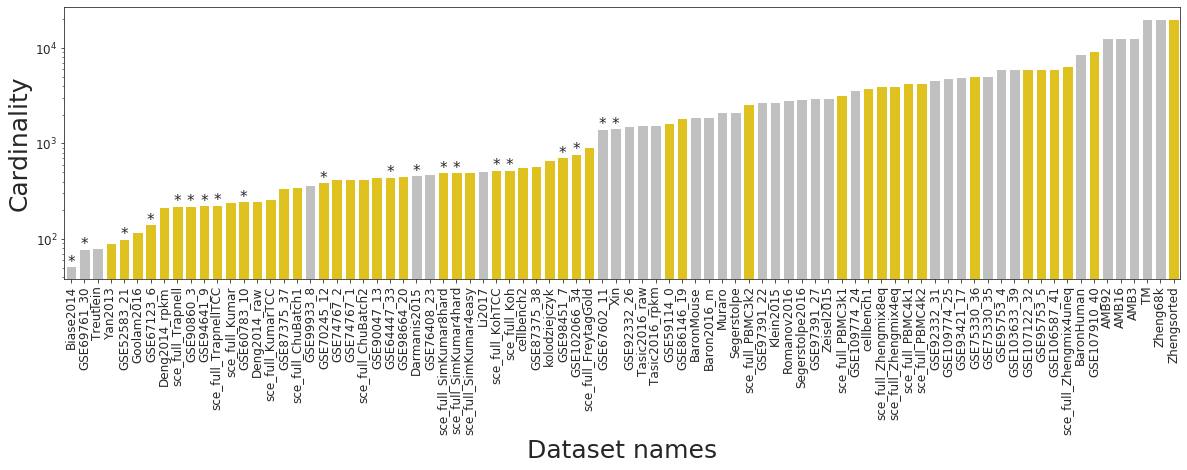

In [11]:
cardinality = pd.DataFrame(pd.Series({k:len(parsed_results_dicts[list(parsed_results_dicts.keys())[0]]['clus']['base'][k]['leiden']) 
                               for k in data_names_unique})).T
cardinality = cardinality.iloc[:,np.argsort(cardinality,axis=1).iloc[0]]
data = pd.concat((cardinality.T,
                  pd.Series(np.isin(data_names_unique,gold_unique),index=data_names_unique),
                  pd.Series(np.isin(data_names_unique,high_id_unique),index=data_names_unique)),axis=1)
data.columns=['cardinality','gold_u','high_id_u']

plt.figure(figsize=(20,5))
barplot=sns.barplot(x='index', y='cardinality',data=data.reset_index(), orient='v',
                    palette=['gold' if x else 'silver' for x in data['gold_u']])

for p, _class in zip(barplot.patches,data['high_id_u']):
    if _class is True:
        barplot.text(p.get_x() + p.get_width() / 2., p.get_height(), 
                     '*', ha='center',fontsize=15)
        
plt.xticks(rotation=90)
plt.yscale('log')
plt.ylabel('Cardinality',fontsize=25)
plt.xlabel('Dataset names',fontsize=25)
plt.savefig('../figures/datasets_summary.png',dpi=300,bbox_inches='tight')

In [15]:
key=list(parsed_results_dicts.keys())[0]
knn_methods = parsed_results_dicts[key]['clus_scores'].keys()
clus_methods = ['louvain','leiden']

all_scores = {}
for clus_method in clus_methods:
    all_scores[clus_method] = {}
    for knn_method in knn_methods:
            all_scores[clus_method][knn_method] = {key:pd.DataFrame(benchmark_common_functions.get_key_df(parsed_results_dicts[key]['clus_scores'][knn_method],clus_method)).T.assign(metric=str(key)+' '+knn_method) 
                                        for key in parsed_results_dicts.keys()}

In [16]:
sns.set_style('whitegrid')

data_keys = data_dict.keys()
score = ('ARI','Homogeneity')
clus_method = ('leiden','louvain')
weighted=(True,)
do_norm = ('duo','seurat')
norm_scale = (True,False)
params_list = list(product(data_keys,score,clus_method,weighted,do_norm,norm_scale))

knn_methods_clus_default_param = ['base_default','scanpy_default_umap','scanpy_default_gauss','mp_normal_default','ls_default','ls_nicdm_default','dsl_default']
knn_methods_clus_adjusted_param = ['base','scanpy_umap', 'scanpy_gauss', 'mp_normal', 'ls', 'ls_nicdm', 'dsl']

for data_key,score,clus_method,weighted,do_norm,norm_scale in params_list:
    print(data_key,score,clus_method,weighted,do_norm,norm_scale)
    #if f'boxplots_{data_key}_{score}_{clus_method}_{do_norm}_{norm_scale}_{weighted}.png' in os.listdir('../figures/'):
    #    continue

    condition_keys = [i for i  in parsed_results_dicts.keys() if i[-2]==do_norm and i[-1] is norm_scale and i[2] is weighted]
    knn_methods = knn_methods_clus_default_param if score == 'Homogeneity' else  knn_methods_clus_adjusted_param

    scores = {}
    for key in condition_keys:
        if 'cosine' in key:
            scores[key]=pd.concat(
                {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods[:-1]}
                                  ,axis=1).assign(metric=str(key))
        else:
            scores[key]=pd.concat(
                {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods}
                                  ,axis=1).assign(metric=str(key))

    cdf = pd.concat(scores)                               # CONCATENATE
    cdf = cdf[cdf.index.isin(data_dict[data_key], level=5)]
    mdf = pd.melt(cdf, id_vars=['metric'], var_name=['cluster_metric']) 
    mdf['metric'] = [x.split(',')[0].split("'")[1] + str(x.split(',')[1])
     for x in mdf['metric']]

    plt.figure(figsize=(25,20))
    ax = sns.boxplot(x="value", y="metric", hue="cluster_metric", data=mdf,showmeans=True,
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"black","markersize":8})  # RUN PLOT   
    ax.scatter(np.nan,np.nan,marker='^',c='w',edgecolors='k',label='mean',linewidth=1.2,s=100)
    ax.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.,fontsize=25)
    xticks=np.arange(0,1.05,.05)
    ax.set_xticks(xticks)
    ax.set_xticklabels(['0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1'])
    ax.set_xlim(-0.03,1.02)
    ax.set_xlabel(f"{score}",fontsize=45)
    ax.set_ylabel("Conditions",fontsize=45)
    ax.tick_params(axis='y',labelsize=30)
    ax.tick_params(axis='x',labelsize=27)

    plt.savefig(f'../figures/boxplots_sqrt_{data_key}_{score}_{clus_method}_{do_norm}_{norm_scale}_{weighted}',dpi=300,bbox_inches='tight')
    plt.close()
    #plt.show()

gold_unique ARI leiden True duo True
gold_unique ARI leiden True duo False
gold_unique ARI leiden True seurat True
gold_unique ARI leiden True seurat False
gold_unique ARI louvain True duo True
gold_unique ARI louvain True duo False
gold_unique ARI louvain True seurat True
gold_unique ARI louvain True seurat False
gold_unique Homogeneity leiden True duo True
gold_unique Homogeneity leiden True duo False
gold_unique Homogeneity leiden True seurat True
gold_unique Homogeneity leiden True seurat False
gold_unique Homogeneity louvain True duo True
gold_unique Homogeneity louvain True duo False
gold_unique Homogeneity louvain True seurat True
gold_unique Homogeneity louvain True seurat False
high_id_unique ARI leiden True duo True
high_id_unique ARI leiden True duo False
high_id_unique ARI leiden True seurat True
high_id_unique ARI leiden True seurat False
high_id_unique ARI louvain True duo True
high_id_unique ARI louvain True duo False
high_id_unique ARI louvain True seurat True
high_id_u

In [61]:
sns.set_style('whitegrid')

score = ('ARI','Homogeneity')
clus_method = ('louvain','leiden')
metric=('cosine','euclidean')
weighted=(True,)
do_norm = ('duo','seurat')
norm_scale = (True,False)
params_list = list(product(score,clus_method,metric,weighted,do_norm,norm_scale))

knn_methods_clus_default_param = ['base_default','scanpy_default_umap','scanpy_default_gauss','mp_normal_default','ls_default','ls_nicdm_default','dsl_default']
knn_methods_clus_adjusted_param = ['base','scanpy_umap', 'scanpy_gauss', 'mp_normal', 'ls', 'ls_nicdm', 'dsl']

for score,clus_method,metric,weighted,do_norm,norm_scale in params_list:
    print(score,clus_method,metric,weighted,do_norm,norm_scale)
    #if f'scatter_scores_{score}_{clus_method}_{metric}_{weighted}_{do_norm}_{norm_scale}.png' in os.listdir('../figures/'):
    #    continue
        
    condition_keys = [i for i  in parsed_results_dicts.keys() if i[-2]==do_norm and i[-1] is norm_scale and i[2] is weighted]
    knn_methods = knn_methods_clus_default_param if score == 'Homogeneity' else  knn_methods_clus_adjusted_param

    scores = {}
    for key in condition_keys:
        if 'cosine' in key:
            scores[key]=pd.concat(
                {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods[:-1]}
                                  ,axis=1).assign(metric=str(key))
        else:
            scores[key]=pd.concat(
                {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods}
                                  ,axis=1).assign(metric=str(key))

    cdf = pd.concat(scores)                               # CONCATENATE

    leveled_mdf = pd.DataFrame(cdf.to_records())
    leveled_mdf = leveled_mdf.drop(['level_2', 'level_3','level_4','metric'], axis=1)
    
    f,axs=plt.subplots(4,1,figsize=(20,20))
    for i0, n_comps in enumerate((25,50,100,500)):
        sel_mdf = leveled_mdf[np.array(leveled_mdf['level_0']==metric) & np.array(leveled_mdf['level_1']==n_comps)].iloc[:,2:]
        mdf = pd.melt(sel_mdf,id_vars='level_5')
        _sort = mdf.loc[mdf['variable'] == knn_methods[0]]['value'].argsort()
        _sort=np.tile(_sort,7)
        for i1 in range(90,630,90):
            _sort[i1:i1+90]+=i1
            
        mdf_sorted = mdf.copy()
        mdf_sorted = mdf.iloc[_sort]
        _ = sns.stripplot(x="level_5", y="value", hue="variable", data=mdf_sorted,size=10,alpha=.5,ax=axs[i0])  # RUN PLOT
        axs[i0].tick_params(labelrotation=90)        
        #axs[i0].set_xticklabels([x.get_text() for x in ax.get_xticklabels()],rotation=90)
        axs[i0].set_ylabel(f'{score} - {n_comps} PCs',fontsize=15)
        axs[i0].set_yticks(np.arange(0,1.05,.1))
        yticks=[(x[:3] if x0%2==0 else '') for x0,x in enumerate(np.arange(0,1.05,.05).astype(str))]
        axs[i0].set_yticklabels(yticks)
        axs[i0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

        axs[i0].set_xlabel('')
        if i0!=0:
            axs[i0].get_legend().remove()
    plt.tight_layout()
    plt.savefig(f'../figures/All_scores/scatter_scores_{score}_{clus_method}_{metric}_{weighted}_{do_norm}_{norm_scale}',dpi=300)
    plt.close()

ARI louvain cosine True duo True
ARI louvain cosine True duo False
ARI louvain cosine True seurat True
ARI louvain cosine True seurat False
ARI louvain euclidean True duo True
ARI louvain euclidean True duo False
ARI louvain euclidean True seurat True
ARI louvain euclidean True seurat False
ARI leiden cosine True duo True
ARI leiden cosine True duo False
ARI leiden cosine True seurat True
ARI leiden cosine True seurat False
ARI leiden euclidean True duo True
ARI leiden euclidean True duo False
ARI leiden euclidean True seurat True
ARI leiden euclidean True seurat False
Homogeneity louvain cosine True duo True
Homogeneity louvain cosine True duo False
Homogeneity louvain cosine True seurat True
Homogeneity louvain cosine True seurat False
Homogeneity louvain euclidean True duo True
Homogeneity louvain euclidean True duo False
Homogeneity louvain euclidean True seurat True
Homogeneity louvain euclidean True seurat False
Homogeneity leiden cosine True duo True
Homogeneity leiden cosine Tr

# Hubness

In [73]:
hub_methods = parsed_results_dicts[list(parsed_results_dicts.keys())[0]]['hubness_dfs'].keys()
hub_measures = parsed_results_dicts[list(parsed_results_dicts.keys())[0]]['hubness_dfs']['base'][list(parsed_results_dicts[list(parsed_results_dicts.keys())[0]]['hubness_dfs']['base'].keys())[0]].index[:5]

hub_scores = {}
for hub_measure in hub_measures:
    hub_scores[hub_measure] = {key:
                               pd.DataFrame(
                                   [
                                    benchmark_common_functions.get_key_df(parsed_results_dicts[key]['hubness_dfs'][hub_method],hub_measure)
                                   for hub_method in hub_methods
                                   ],index=hub_methods).T.assign(metric=str(key))
                               
                                    for key in parsed_results_dicts.keys()}

In [74]:
for key in parsed_results_dicts.keys():
    hub_scores['k_skewness'][key].insert(loc=1, column='scanpy_umap', value=pd.DataFrame(results_dicts[key]).T['umap'])
    hub_scores['k_skewness'][key].insert(loc=2, column='scanpy_gauss', value=pd.DataFrame(results_dicts[key]).T['gauss'])

In [75]:
sns.set_style('whitegrid')

hub_score = 'k_skewness'

data_keys = data_dict.keys()
weighted=(True,)
do_norm = ('duo','seurat')
norm_scale = (True,False)
params_list = list(product(data_keys,weighted,do_norm,norm_scale))

for data_key,weighted,do_norm,norm_scale in params_list:
    print(data_key,weighted,do_norm,norm_scale)
    condition_keys = [i for i  in parsed_results_dicts.keys() if i[-2]==do_norm and i[-1] is norm_scale and i[2] is weighted]

    #remove dsl for cosine
    for key in condition_keys:
        if 'cosine' in key:
            try:
                del hub_scores[hub_score][key]['dsl']
            except:
                pass

    cdf = pd.concat({k:hub_scores[hub_score][k] for k in condition_keys})                               # CONCATENATE
    cdf = cdf[cdf.index.isin(data_dict[data_key], level=5)]
    mdf = pd.melt(cdf, id_vars=['metric'], var_name=['hub_method']) 
    mdf['metric'] = [x.split(',')[0].split("'")[1] + str(x.split(',')[1])
     for x in mdf['metric']]

    plt.figure(figsize=(15,10))
    ax = sns.boxplot(x="value", y="metric", hue="hub_method", data=mdf,showmeans=True,
                    meanprops={"markerfacecolor":"white", "markeredgecolor":"black"})  # RUN PLOT   
    ax.scatter(np.nan,np.nan,marker='^',c='w',edgecolors='k',label='mean',linewidth=1.2)

    ax.legend(bbox_to_anchor=(1, 1), borderaxespad=0.,fontsize=20)
    #ax.set_xticks(np.arange(0,np.max(mdf['value']),2))

    ax.set_xlabel('k-skewness',fontsize=25)
    ax.set_ylabel("Conditions",fontsize=25)
    ax.tick_params(labelsize=20)
    plt.savefig(f'../figures/boxplots_hubness_{data_key}_{hub_score}_{do_norm}_{norm_scale}_{weighted}',dpi=300,bbox_inches='tight')
    plt.close()

gold_unique True duo True
gold_unique True duo False
gold_unique True seurat True
gold_unique True seurat False
high_id_unique True duo True
high_id_unique True duo False
high_id_unique True seurat True
high_id_unique True seurat False
data_names_unique True duo True
data_names_unique True duo False
data_names_unique True seurat True
data_names_unique True seurat False


In [55]:
hub_score = 'k_skewness'
metric=('cosine','euclidean')
n_comps=(25,50,100,500)
weighted=(True,)
do_norm = ('duo','seurat')#,'zheng17')
norm_scale = (True,False)
params_list = list(product(metric,weighted,do_norm,norm_scale))

for metric,weighted,do_norm,norm_scale in params_list:
    print(metric,weighted,do_norm,norm_scale)
    condition_keys = [i for i  in parsed_results_dicts.keys() if i[-2]==do_norm and i[-1] is norm_scale and i[2] is weighted]
    for key in condition_keys:
        if 'cosine' in key:
            try:
                del hub_scores[hub_score][key]['dsl']
            except:
                pass

    cdf = pd.concat({k:hub_scores[hub_score][k] for k in condition_keys})                               # CONCATENATE
    leveled_mdf2 = pd.DataFrame(cdf.to_records())
    leveled_mdf2 = leveled_mdf2.drop(['level_2', 'level_3','level_4','metric','mp_normal'], axis=1)
    
    f,axs=plt.subplots(4,1,figsize=(20,20))
    for i0, n_comps in enumerate((25,50,100,500)):

        #idx_rename = ['/' in x for x in  leveled_mdf2['level_5']]
        #leveled_mdf2.loc[idx_rename,'level_5'] = [x.split('/')[-1] for x in leveled_mdf2['level_5'][idx_rename]]

        sel_mdf = leveled_mdf2[np.array(leveled_mdf2['level_0']==metric) & np.array(leveled_mdf2['level_1']==n_comps)].iloc[:,2:]
        mdf = pd.melt(sel_mdf,id_vars='level_5')
        
        _sort = mdf.loc[mdf['variable'] == 'base']['value'].argsort()
        _sort=np.tile(_sort,4)
        for i1 in range(90,360,90):
            _sort[i1:i1+90]+=i1

        mdf_sorted = mdf.copy()
        mdf_sorted = mdf.iloc[_sort]
        _ = sns.stripplot(x="level_5", y="value", hue="variable", data=mdf_sorted,size=10,alpha=.5,ax=axs[i0])  # RUN PLOT
        axs[i0].tick_params(labelrotation=90)        
        #axs[i0].set_xticklabels([x.get_text() for x in ax.get_xticklabels()],rotation=90)
        axs[i0].set_ylabel(f'{score} - {n_comps} PCs',fontsize=15)
        #axs[i0].set_yticks(np.arange(0,1.05,.1))
        #yticks=[(x[:3] if x0%2==0 else '') for x0,x in enumerate(np.arange(0,1.05,.05).astype(str))]
        #axs[i0].set_yticklabels(yticks)
        axs[i0].legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0.)

        axs[i0].set_xlabel('')
        if i0!=0:
            axs[i0].get_legend().remove()
    plt.tight_layout()
    plt.savefig(f'../figures/All_hubness/scatter_hubness_{metric}_{hub_score}_{weighted}_{do_norm}_{norm_scale}',dpi=300,bbox_inches='tight')
    plt.close()

cosine True duo True
cosine True duo False
cosine True seurat True
cosine True seurat False
euclidean True duo True
euclidean True duo False
euclidean True seurat True
euclidean True seurat False


# ID

In [13]:
#vary params
n_comps=(25,50,100,500)
do_norm = ('seurat','duo')
norm_scale = (True,False)
params_list = list(product(n_comps,do_norm,norm_scale))

In [14]:
gid = {}
lid = {}
for k in params_list:
    n_comps,do_norm,norm_scale = k
    print(n_comps,do_norm,norm_scale)
    gid[k], lid[k] = {}, {}
    gid[k][k], lid[k][k] = {}, {}
    
    resdir = '../results/scRNAseq_Benchmark_datasets/'
    with open(resdir+f'all_id_pca_abdelaal{n_comps}_{do_norm}_{norm_scale}.pkl','rb') as f:
        _gid1, _lid1 = pickle.load(f)

    resdir = '../results/DuoClustering2018/sce_full/'
    with open(resdir+f'all_id_duo_raw{n_comps}_{do_norm}_{norm_scale}.pkl','rb') as f:
        _gid2, _lid2 = pickle.load(f)

    resdir = '../results/Cytotrace_raw_datasets/hubness_results/'
    with open(resdir+f'all_id_cytotrace_raw{n_comps}_{do_norm}_{norm_scale}.pkl','rb') as f:
        _gid3, _lid3 = pickle.load(f)
        
    resdir = '../results/benchmark_sensitivity_frontiers/real_data/'
    with open(resdir+f'all_id_krzak_{n_comps}_{do_norm}_{norm_scale}.pkl','rb') as f:
        _gid4, _lid4 = pickle.load(f)
            
    resdir = '../results/Freytag_datasets/'
    with open(resdir+f'all_id_freytag_{n_comps}_{do_norm}_{norm_scale}.pkl','rb') as f:
        _gid5, _lid5 = pickle.load(f)


    for m in ['fisher','twonn','pca','danco']:
        gid[k][k][m] = {**_gid1[k][m],**_gid2[k][m],**_gid3[k][m],**_gid4[k][m],**_gid5[k][m]}
        lid[k][k][m] = {**_lid1[k][m],**_lid2[k][m],**_lid3[k][m],**_lid4[k][m],**_lid5[k][m]}
        
gid={k:pd.DataFrame(v[k]).assign(metric=str(k)) for k,v in gid.items()}
lid={k:pd.DataFrame(v[k]).assign(metric=str(k)) for k,v in lid.items()}

25 seurat True
25 seurat False
25 duo True
25 duo False
50 seurat True
50 seurat False
50 duo True
50 duo False
100 seurat True
100 seurat False
100 duo True
100 duo False
500 seurat True
500 seurat False
500 duo True
500 duo False


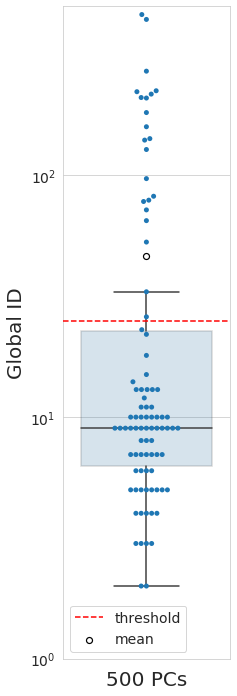

In [39]:
sns.set_style('whitegrid')
do_norm = 'seurat'
norm_scale = True
condition_keys = [k for k in gid.keys() if k[0]==500 and k[1]==do_norm and k[2] is norm_scale]

_gid,_lid = {}, {}
for k in condition_keys:
    _gid[k]=gid[k]
    _lid[k]=lid[k]
    
cdf = pd.concat(_gid)
mdf = pd.melt(cdf[['pca','metric']], id_vars=['metric'], var_name=['id_method']) 
mdf['metric']= [x.split(',')[0][1:]+" PCs" for x in mdf['metric']]
means = [
    mdf[mdf['metric']=='25 PCs']['value'].mean(),
    mdf[mdf['metric']=='50 PCs']['value'].mean(),
    mdf[mdf['metric']=='100 PCs']['value'].mean(),
    mdf[mdf['metric']=='500 PCs']['value'].mean()]
mdf['metric']= ["" for x in mdf['metric']]
#ax=sns.swarmplot(x="value", y="metric", hue="id_method", data=mdf)  #
plt.figure(figsize=(3,12))
ax=plt.subplot()
ax.set_yscale('log')
ax=sns.swarmplot(y="value", x="metric", hue="id_method", data=mdf,ax=ax,orient='v')  #
ax=sns.boxplot(y="value", x="metric", hue="id_method", data=mdf,ax=ax,showmeans=False,orient='v',fliersize=0,
                boxprops=dict(alpha=.2))#,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"})


#ax.set_xticks(np.arange(0,500,25))
#ax.set_xticklabels(np.arange(0,500,25))
#ax.get_legend().remove()
ax.scatter([0],means[-1],marker='o',c='w',edgecolors='k',label='mean',zorder=3,linewidth=1.2)
ax.axhline(y=25,c='r',linestyle='--',zorder=10,label="threshold")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:1]+handles[-1:],labels=labels[:1]+labels[-1:])
ax.set_ylim((1,500))
ax.set_ylabel('Global ID',fontsize=20)
ax.set_xlabel('500 PCs',fontsize=20)
plt.savefig(f'../figures/GID_PCA_{do_norm}_{norm_scale}',dpi=300,bbox_inches='tight')

/home/jo/anaconda3/envs/w/lib/python3.7/site-packages/pandas/core/frame.py:6942: RuntimeWarning: Mean of empty slice
  return lib.map_infer(x.astype(object).values, func)


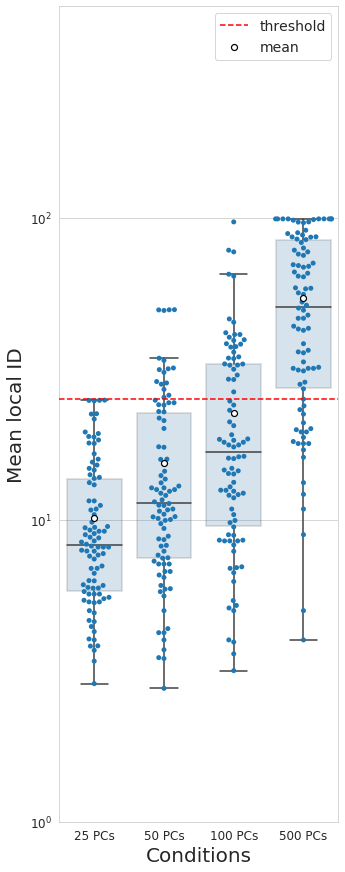

In [167]:
sns.set_style('whitegrid')
do_norm = 'seurat'
norm_scale = True
condition_keys = [k for k in gid.keys() if k[1]==do_norm and k[2] is norm_scale]

_gid,_lid = {}, {}
for k in condition_keys:
    _gid[k]=gid[k]
    _lid[k]=lid[k]
    
cdf = pd.concat(_lid)
cdf.iloc[:,:-1] = cdf.iloc[:,:-1].applymap(np.nanmean)
mdf = pd.melt(cdf[['pca','metric']], id_vars=['metric'], var_name=['id_method']) 
mdf['metric']= [x.split(',')[0][1:]+" PCs" for x in mdf['metric']]
#ax=sns.swarmplot(x="value", y="metric", hue="id_method", data=mdf)  #
plt.figure(figsize=(5,15))
ax=plt.subplot()
ax.set_yscale('log')
ax=sns.swarmplot(y="value", x="metric", hue="id_method", data=mdf,ax=ax,orient='v')  #
ax=sns.boxplot(y="value", x="metric", hue="id_method", data=mdf,ax=ax,showmeans=False,orient='v',fliersize=0,
                boxprops=dict(alpha=.2))#,meanprops={"markerfacecolor":"white", "markeredgecolor":"black"})
means = [
    mdf[mdf['metric']=='25 PCs']['value'].mean(),
    mdf[mdf['metric']=='50 PCs']['value'].mean(),
    mdf[mdf['metric']=='100 PCs']['value'].mean(),
    mdf[mdf['metric']=='500 PCs']['value'].mean()]
#ax.set_xticks(np.arange(0,500,25))
#ax.set_xticklabels(np.arange(0,500,25))
#ax.get_legend().remove()
ax.scatter(range(4),means,marker='o',c='w',edgecolors='k',label='mean',zorder=3,linewidth=1.2)
ax.axhline(y=25,c='r',linestyle='--',zorder=10,label="threshold")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:1]+handles[-1:],labels=labels[:1]+labels[-1:])
ax.set_ylim((1,500))
ax.set_ylabel('Mean local ID',fontsize=20)
ax.set_xlabel('Conditions',fontsize=20)
plt.savefig(f'../figures/LID_PCA_{do_norm}_{norm_scale}',dpi=300,bbox_inches='tight')

In [102]:
hub_score = 'k_skewness'
score = 'ARI'
clus_method = 'leiden'
metric='euclidean'
weighted=True
do_norm = 'seurat'
norm_scale = True
n_comps = [500]

knn_methods_clus_default_param = ['base_default','scanpy_default_umap','scanpy_default_gauss','mp_normal_default','ls_default','ls_nicdm_default','dsl_default']
knn_methods_clus_adjusted_param = ['base','scanpy_umap', 'scanpy_gauss', 'mp_normal', 'ls', 'ls_nicdm', 'dsl']

        
condition_keys = [i for i  in parsed_results_dicts.keys() if i[0]==metric and i[1] in n_comps and i[2] is weighted and i[3]==do_norm and i[4] is norm_scale]


### clustering scores
knn_methods = knn_methods_clus_default_param if score == 'Homogeneity' else  knn_methods_clus_adjusted_param
scores = {}
for key in condition_keys:
    if 'cosine' in key:
        scores[key]=pd.concat(
            {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods[:-1]}
                              ,axis=1).assign(metric=str(key))
    else:
        scores[key]=pd.concat(
            {knn_method:all_scores[clus_method][knn_method][key][score] for knn_method in knn_methods}
                              ,axis=1).assign(metric=str(key))

cdf = pd.concat(scores)                               # CONCATENATE

leveled_mdf = pd.DataFrame(cdf.to_records())
leveled_mdf = leveled_mdf.drop(['level_2', 'level_3','level_4','metric']+knn_methods[1:4], axis=1)
    
#### hubness scores
cdf = pd.concat({k:hub_scores[hub_score][k] for k in condition_keys})                               # CONCATENATE

leveled_mdf2 = pd.DataFrame(cdf.to_records())
leveled_mdf2 = leveled_mdf2.drop(['level_2', 'level_3','level_4','metric','mp_normal'], axis=1)


### id
id_condition_keys = [k for k in gid.keys() if k[0] in n_comps and k[1]==do_norm and k[2] is norm_scale]

_gid,_lid = {}, {}
for k in id_condition_keys:
    _gid[k]=gid[k]
    _lid[k]=lid[k]
    
cdf = pd.concat(_gid)
#cdf.iloc[:,:-1] = cdf.iloc[:,:-1].applymap(np.nanmean)
leveled_mdf3 = pd.DataFrame(cdf.to_records())
leveled_mdf3 = leveled_mdf3.drop(['level_1','level_2','metric'], axis=1)

#idx_rename = ['/' in x for x in  leveled_mdf3['level_3']]
leveled_mdf3['level_3'] = [x.split('/')[-1] for x in leveled_mdf3['level_3']]
leveled_mdf3['level_3'] = [x.split('.')[0] for x in leveled_mdf3['level_3']]
leveled_mdf3['level_3'] = [x.split('raw_')[-1] for x in leveled_mdf3['level_3']]

cdf = pd.concat(_lid)
cdf.iloc[:,:-1] = cdf.iloc[:,:-1].applymap(np.nanmean)
leveled_mdf4 = pd.DataFrame(cdf.to_records())
leveled_mdf4 = leveled_mdf4.drop(['level_1','level_2','metric'], axis=1)

#idx_rename = ['/' in x for x in  leveled_mdf3['level_3']]
leveled_mdf4['level_3'] = [x.split('/')[-1] for x in leveled_mdf4['level_3']]
leveled_mdf4['level_3'] = [x.split('.')[0] for x in leveled_mdf4['level_3']]
leveled_mdf4['level_3'] = [x.split('raw_')[-1] for x in leveled_mdf4['level_3']]

/home/jo/anaconda3/envs/w/lib/python3.7/site-packages/pandas/core/frame.py:6942: RuntimeWarning: Mean of empty slice
  return lib.map_infer(x.astype(object).values, func)


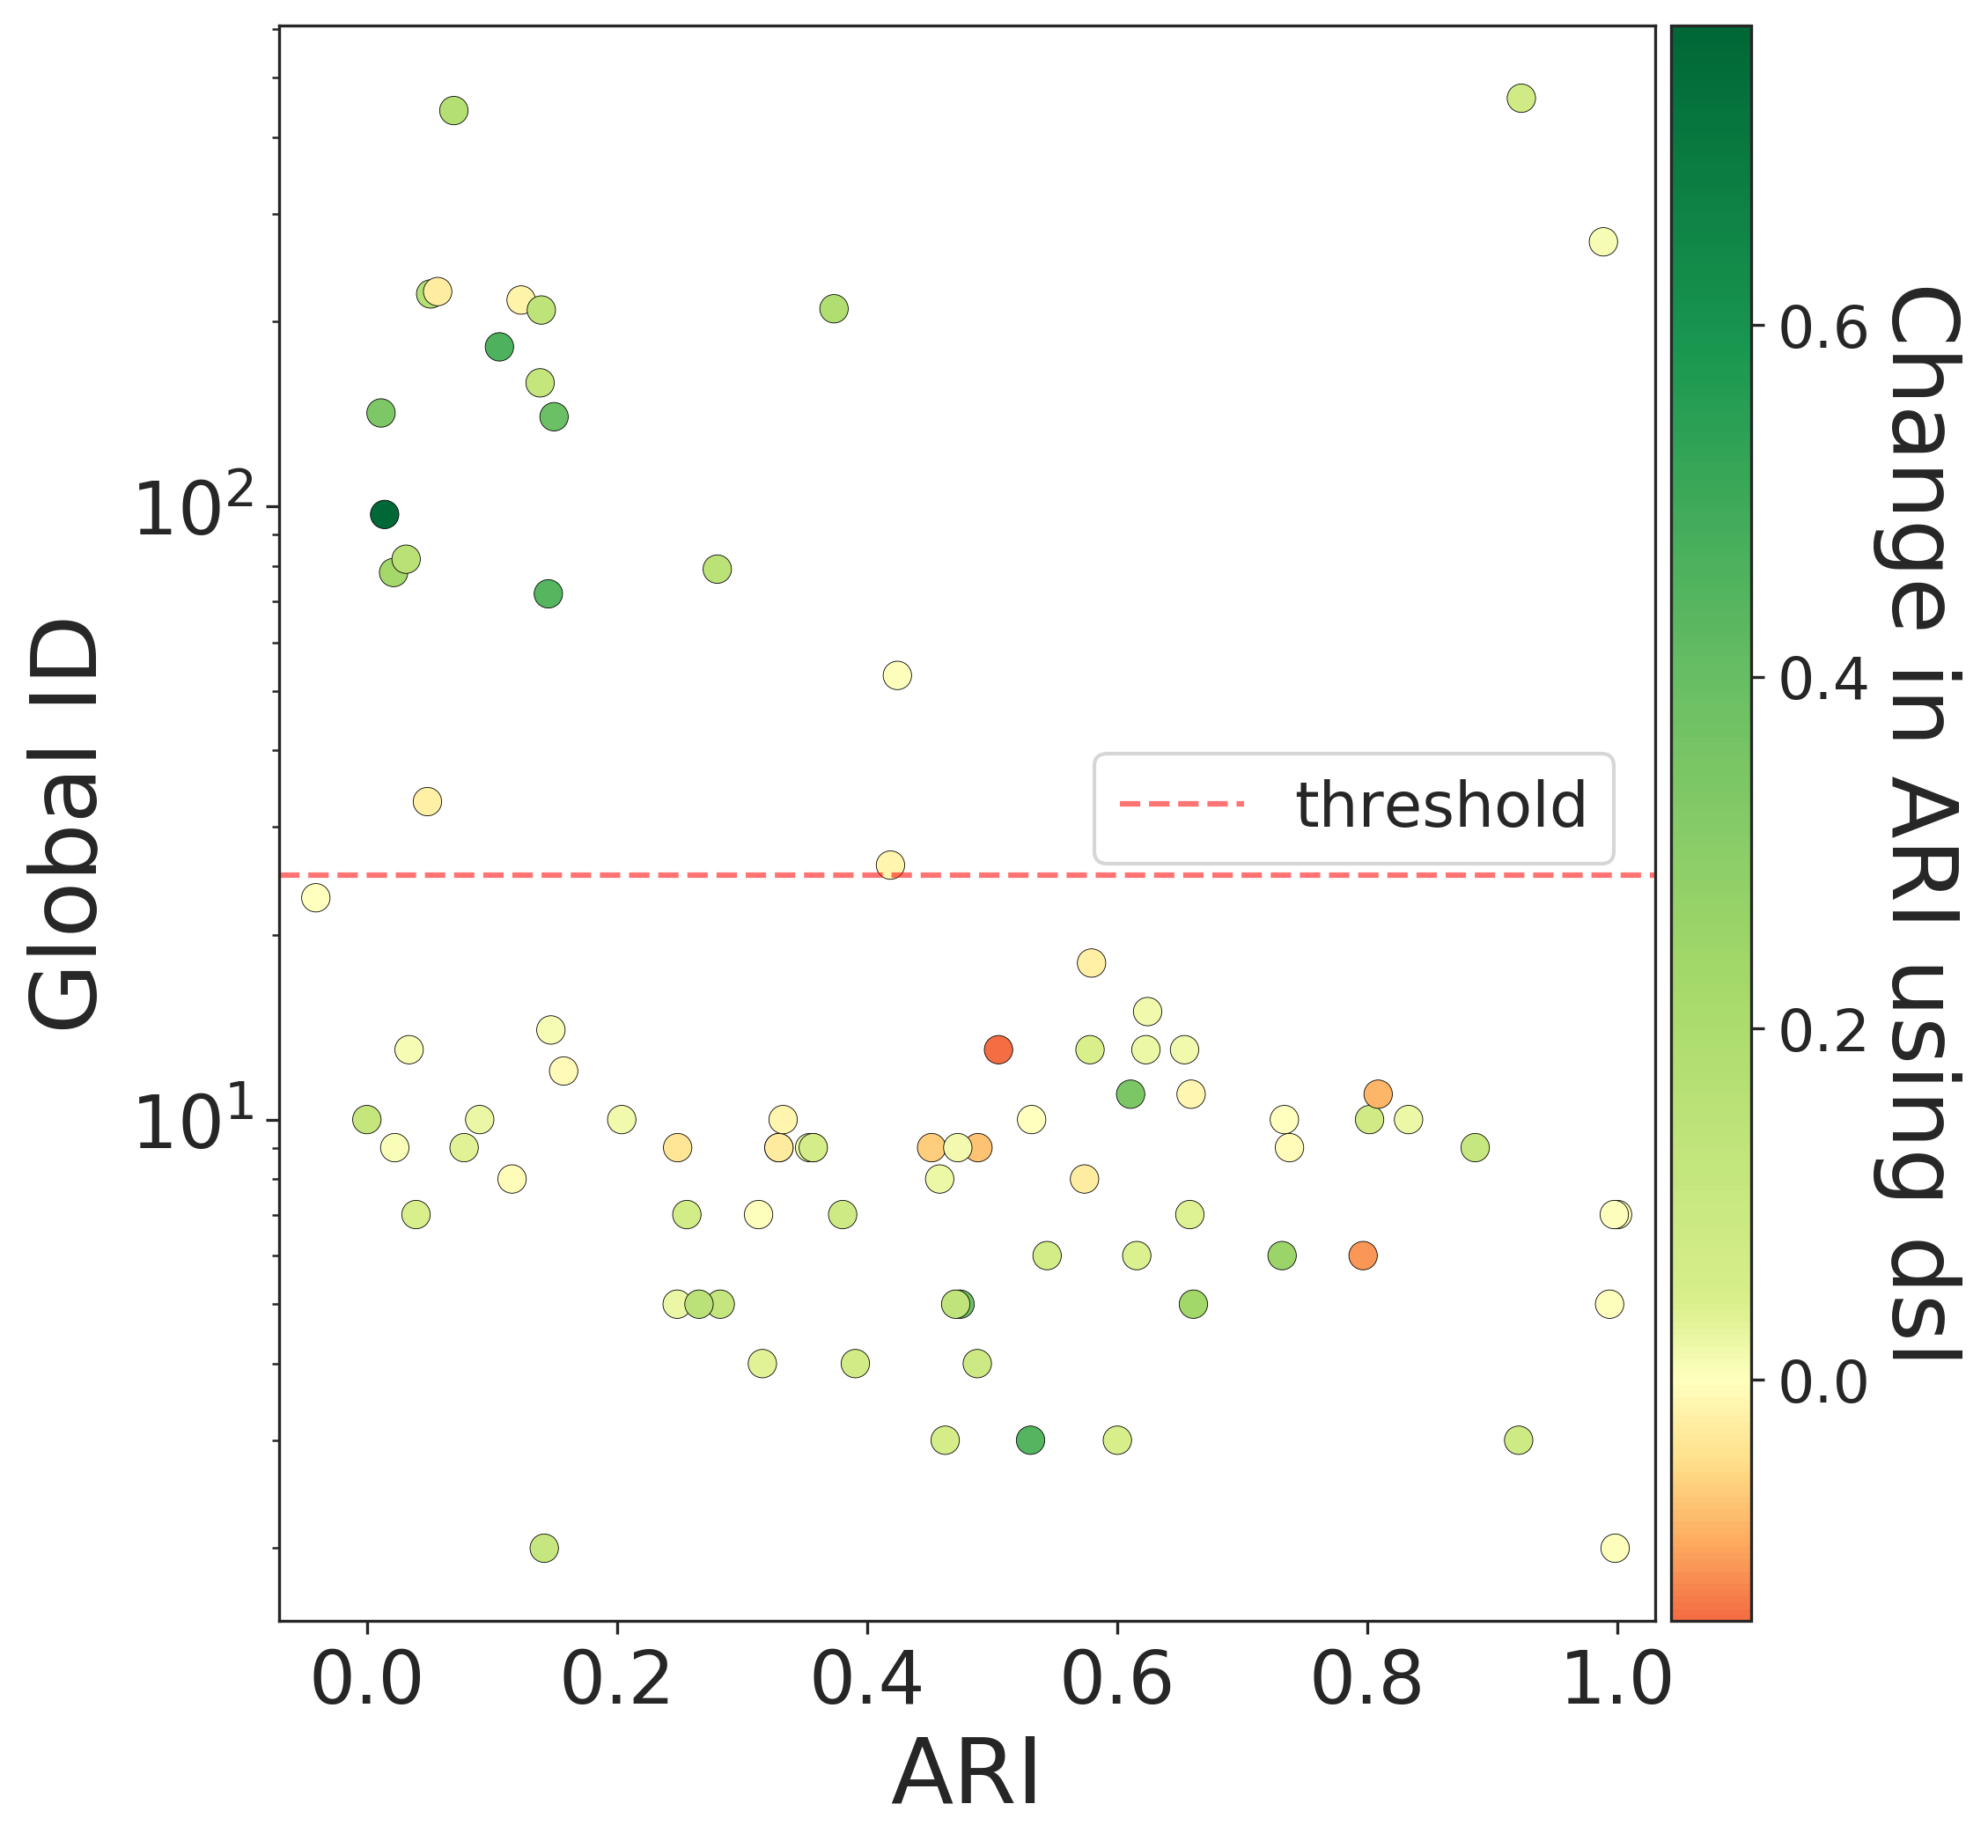

In [188]:
sns.set_style('ticks')
sel_mdf_x = leveled_mdf2[np.isin(np.array(leveled_mdf2['level_5']), data_filter)]

sel_mdf_z = leveled_mdf[np.isin(np.array(leveled_mdf['level_5']), data_filter)]

k = 'pca'

##################################################

#gid
sel_mdf_y = leveled_mdf3[np.isin(np.array(leveled_mdf3['level_3']), data_filter)]

f=plt.figure(figsize=(8,8),dpi=300)
ax=plt.subplot()
_cor = pg.corr(sel_mdf_y[k].astype(float),sel_mdf_z['base'])
cor = _cor['r'][0]
pval=_cor['p-val'][0]
ci95_l, ci95_h = _cor['CI95%'][0][0], _cor['CI95%'][0][1]

#ax.set_title(f'Coeff. {cor:.2f}    CI95 ({ci95_l:.2f}-{ci95_h:.2f})\n p-val {pval:.1e}',fontsize=20)
ax.set_ylabel('Global ID',fontsize=25)
ax.set_xlabel('ARI',fontsize=25)
_=ax.scatter(sel_mdf_z['base'],sel_mdf_y[k],alpha=1,s=60, cmap=shiftedColorMap(plt.cm.RdYlGn,start=.2,midpoint=.2),linewidth=.2,edgecolor='k',
           c=np.array(sel_mdf_z['dsl']-sel_mdf_z['base'])
          #( np.array(sel_mdf_y[k] >= 25) & 
             #(np.array(sel_mdf_z['dsl']-sel_mdf_z['base']) > 0)
            #np.array(sel_mdf_x['base'] >= np.mean(sel_mdf_x['base'])))
            )
ax.tick_params(labelsize=20)
ax.axhline(25,c='red',linestyle='--',label='threshold',alpha=.55)   
ax.legend(fontsize=17,bbox_to_anchor=(.57,.455))
ax.set_yscale('log')
ax.set_xlim(-0.07,1.03)
cbar = plt.colorbar(_,pad=0.01)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_ylabel('Change in ARI using dsl', rotation=270,fontsize=25)
plt.savefig('../figures/GIDvsARI.png',dpi=300,bbox_inches='tight')

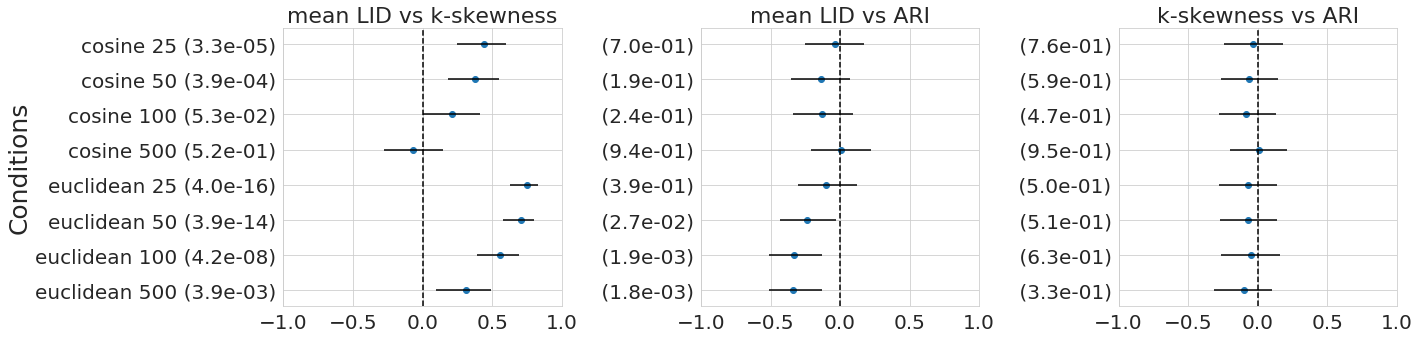

In [219]:
sns.set_style('whitegrid')
f,axs = plt.subplots(1,3,figsize=(20,5))
axs=axs.flat
hub_measure = 'k_skewness'
hub_method='ls'
clus_method = 'leiden'
preproc = 'seurat'
metric = 'ARI'
id_method = 'pca'
keys = [i for i in parsed_results_dicts.keys() if preproc in i and i[-1] is True]
score_keys = data_names_unique

(hubscores, hubscores_after, hubscores_change,
 clusscores, clusscores_after, clusscores_change)  = get_hub_clus_scores(parsed_results_dicts, 
                                                                         hub_measure = hub_measure, hub_method = hub_method, 
                                                                         clus_method = clus_method, metric = metric)


ax = next(axs)
corr = get_corr_lid(keys,lid,hubscores,id_method,score_keys)
corr = fix_nan_corr(corr)
corr.columns = [x.split(',')[0].split("'")[1] + str(x.split(',')[1]) + f' ({p:.1e})'
 for x,p in zip(corr.columns,[p[0] for p in corr.loc['p-val']])]
corr=corr.iloc[:,::-1]
low, high = map(list, zip(*corr.loc['CI']))
ax.axvline(color='k', linestyle='--')
#ax.axhline(y=7.5,color='b')
ax.hlines(range(corr.shape[1]),low,high)
ax.scatter(corr.loc['coef'].astype(float),corr.columns,marker='o')
ax.set_xlim(-1,1)
ax.set_title(f'mean LID vs k-skewness',fontsize=22)
ax.set_ylabel('Conditions',fontsize=25)
ax.tick_params(labelsize=20)


ax = next(axs)
corr = get_corr_lid(keys,lid,clusscores,id_method,score_keys)
corr = fix_nan_corr(corr)
corr.columns = [f' ({p:.1e})'
 for x,p in zip(corr.columns,[p[0] for p in corr.loc['p-val']])]
corr=corr.iloc[:,::-1]
low, high = map(list, zip(*corr.loc['CI']))
ax.axvline(color='k', linestyle='--')
#ax.axhline(y=7.5,color='b')
ax.hlines(range(corr.shape[1]),low,high)
ax.scatter(corr.loc['coef'].astype(float),corr.columns,marker='o')
ax.set_xlim(-1,1)
ax.set_title(f'mean LID vs ARI',fontsize=22)
ax.tick_params(labelsize=20)

#ax = next(axs)
#corr = get_corr_id(keys,gid,hubscores,id_method,score_keys)
#corr.columns = [f' (pval. {p:.1e})'
# for x,p in zip(corr.columns,[p[0] for p in corr.loc['p-val']])]
#low, high = map(list, zip(*corr.loc['CI']))
#ax.axvline(color='k', linestyle='--')
##ax.axhline(y=7.5,color='b')
#ax.hlines(range(corr.shape[1]),low,high)
#ax.scatter(corr.loc['coef'].astype(float),corr.columns,marker='o')
#ax.set_xlim(-1,1)
#ax.set_title(f'GID vs k-skewness')
#
#ax = next(axs)
#corr = get_corr_id(keys,gid,clusscores,id_method,score_keys)
#corr.columns = [f' (pval. {p:.1e})'
# for x,p in zip(corr.columns,[p[0] for p in corr.loc['p-val']])]
#low, high = map(list, zip(*corr.loc['CI']))
#ax.axvline(color='k', linestyle='--')
##ax.axhline(y=7.5,color='b')
#ax.hlines(range(corr.shape[1]),low,high)
#ax.scatter(corr.loc['coef'].astype(float),corr.columns,marker='o')
#ax.set_xlim(-1,1)
#ax.set_title(f'GID vs ARI')


ax = next(axs)
corr = get_corr_hub(keys,hubscores,clusscores)
corr.columns = [f' ({p:.1e})'
 for x,p in zip(corr.columns,[p[0] for p in corr.loc['p-val']])]
corr=corr.iloc[:,::-1]
low, high = map(list, zip(*corr.loc['CI']))
ax.set_title(f'k-skewness vs ARI',fontsize=22)
ax.axvline(color='k', linestyle='--')
#ax.axhline(y=7.5,color='b')
ax.hlines(range(corr.shape[1]),low,high)
ax.scatter(corr.loc['coef'].astype(float),corr.columns,marker='o')
ax.set_xlim(-1,1)
ax.tick_params(labelsize=20)

plt.tight_layout()
plt.savefig('../figures/correlations.png',dpi=300)